In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2349464cba7ceccd57a28891a47acde36aabc181375797f761a5ac3a075920c3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f75e1de772eee67a147a1cd65841fbc216f1006ea12f991004cf9132ba34751a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import os
import gc 
import cv2
import random

from tqdm.auto import tqdm
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

In [3]:
def seed_everything(seed=100):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [4]:
# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 100   
LR = 0.0001    
IMG_SIZE = 256 
BATCH_SIZE = 8

In [5]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels")
train_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels",x),masks)})
print(train_df.shape)
del images, masks
train_df.head()

(126, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...


In [6]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels")
val_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels",x),masks)})
print(val_df.shape)
del images, masks
val_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...


In [7]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels")
test_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels",x),masks)})
print(test_df.shape)
del images, masks
test_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...


In [8]:
def encode_labels(masks):
    labelencoder = LabelEncoder()
    masks_reshaped = masks.reshape(-1)
    masks_encoded = labelencoder.fit_transform(masks_reshaped)
    del masks_reshaped, labelencoder
    return masks_encoded.reshape(masks.shape)

In [9]:
# Create a custom dataset class
classes=226
class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df
        images=[]
        masks=[]
        for idx in range(len(self.df)):
            sample = self.df.iloc[idx]
#             images.append(load_img(sample.images, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
#             masks.append(load_img(sample.masks, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
            images.append(cv2.resize(cv2.imread(sample.images, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)))
            masks.append(cv2.resize(cv2.imread(sample.masks, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)))
        images = np.array(images)
        masks = np.array(masks)
        n_classes = len(np.unique(masks))
        masks_encoded = encode_labels(masks)
        self.masks_cat = to_categorical(masks_encoded, num_classes=n_classes)
        self.images = np.expand_dims(images, axis=-1) / 255.0
        del masks_encoded, images, masks, n_classes
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = torch.from_numpy(np.transpose(self.images[idx],(2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(self.masks_cat[idx],(2, 0, 1))).float()
        return image, mask

In [10]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df)
val_data = SegmentationDataset(val_df)
test_data = SegmentationDataset(test_df)

In [11]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 126
Size of Validset : 40


In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 16
Total number of batches in Val Loader: 5


In [14]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([8, 1, 256, 256])
Size of one batch of masks: torch.Size([8, 226, 256, 256])


In [15]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

In [16]:
def dice_score(y_true, y_pred):
    return 1.0-DiceLoss(mode="binary")(y_true, y_pred)
            
def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15)

In [17]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x, masks):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        loss = DiceLoss(mode='binary')(logits, masks)
        score = dice_score(logits, masks)
        return logits, loss, score

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [19]:
model = UNet(n_channels=1, n_classes=classes)
model.to(DEVICE);

In [20]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    total_score = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss, score = model(images, masks)
        loss.backward()
        optimizer.step()
        total_score += score.item()
        total_loss += loss.item()

    return total_loss / len(data_loader), total_score / len(data_loader)

In [21]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    total_score = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss, score = model(images, masks)

            total_score += score.item()
            total_loss += loss.item()

        return total_loss / len(data_loader), total_score / len(data_loader)

In [22]:
# Define the optimizer 
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

In [23]:
gc.collect()

72

In [24]:
# Training and evaluation loop
best_val_loss = 1e9
writer=SummaryWriter("DiceLoss_Clean_Dataset")
for i in range(EPOCHS):
    train_loss, train_score = train_model(trainloader, model, optimizer)
    val_loss, val_score = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_DiceLoss_Clean_model_SD.pt')
        torch.save(model, 'best_DiceLoss_Clean_model.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss
    writer.add_scalar("Loss/train", train_loss, i)
    writer.add_scalar("Loss/val", val_loss, i)
    writer.add_scalar("Score/train", train_score, i)
    writer.add_scalar("Score/val", val_score, i)
    writer.flush()
    print(f"\033[1m\033[92m Epoch {i+1} Train DiceLoss {train_loss} Val DiceLoss {val_loss} Train dice_score {train_score} Val dice_score {val_score}")
writer.close()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 1 Train DiceLoss 0.986475296318531 Val DiceLoss 0.9896884799003601 Train dice_score 0.013524703681468964 Val dice_score 0.010311520099639893


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 2 Train DiceLoss 0.983757883310318 Val DiceLoss 0.9863253593444824 Train dice_score 0.016242116689682007 Val dice_score 0.013674640655517578


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 3 Train DiceLoss 0.9822754599153996 Val DiceLoss 0.984277856349945 Train dice_score 0.01772454008460045 Val dice_score 0.01572214365005493


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 4 Train DiceLoss 0.9809544533491135 Val DiceLoss 0.9806703448295593 Train dice_score 0.019045546650886536 Val dice_score 0.019329655170440673


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 5 Train DiceLoss 0.9796720631420612 Val DiceLoss 0.9789248108863831 Train dice_score 0.020327936857938766 Val dice_score 0.021075189113616943


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 6 Train DiceLoss 0.9783881157636642 Val DiceLoss 0.9776505470275879 Train dice_score 0.021611884236335754 Val dice_score 0.022349452972412108


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 7 Train DiceLoss 0.9770282357931137 Val DiceLoss 0.9762816071510315 Train dice_score 0.02297176420688629 Val dice_score 0.023718392848968504


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 8 Train DiceLoss 0.9755535945296288 Val DiceLoss 0.9746365785598755 Train dice_score 0.024446405470371246 Val dice_score 0.02536342144012451


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 9 Train DiceLoss 0.9739290699362755 Val DiceLoss 0.9733344197273255 Train dice_score 0.026070930063724518 Val dice_score 0.02666558027267456


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 10 Train DiceLoss 0.9721649698913097 Val DiceLoss 0.9719535946846009 Train dice_score 0.027835030108690262 Val dice_score 0.02804640531539917


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 11 Train DiceLoss 0.9702506437897682 Val DiceLoss 0.9691333889961242 Train dice_score 0.02974935621023178 Val dice_score 0.03086661100387573


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 12 Train DiceLoss 0.9680990390479565 Val DiceLoss 0.966890013217926 Train dice_score 0.03190096095204353 Val dice_score 0.033109986782073976


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 13 Train DiceLoss 0.9657772853970528 Val DiceLoss 0.9640587329864502 Train dice_score 0.034222714602947235 Val dice_score 0.035941267013549806


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 14 Train DiceLoss 0.9631920792162418 Val DiceLoss 0.962324035167694 Train dice_score 0.03680792078375816 Val dice_score 0.03767596483230591


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 15 Train DiceLoss 0.9604531340301037 Val DiceLoss 0.9594082355499267 Train dice_score 0.039546865969896317 Val dice_score 0.040591764450073245


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 16 Train DiceLoss 0.9575081579387188 Val DiceLoss 0.9554271578788758 Train dice_score 0.042491842061281204 Val dice_score 0.044572842121124265


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 17 Train DiceLoss 0.9542157649993896 Val DiceLoss 0.9536359667778015 Train dice_score 0.04578423500061035 Val dice_score 0.04636403322219849


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 18 Train DiceLoss 0.9505148939788342 Val DiceLoss 0.9504284620285034 Train dice_score 0.04948510602116585 Val dice_score 0.04957153797149658


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 19 Train DiceLoss 0.9471263214945793 Val DiceLoss 0.9589374184608459 Train dice_score 0.052873678505420685 Val dice_score 0.041062581539154056


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 20 Train DiceLoss 0.9425639547407627 Val DiceLoss 0.9394919514656067 Train dice_score 0.05743604525923729 Val dice_score 0.06050804853439331


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 21 Train DiceLoss 0.9375782981514931 Val DiceLoss 0.9341284751892089 Train dice_score 0.06242170184850693 Val dice_score 0.06587152481079102


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 22 Train DiceLoss 0.9324210211634636 Val DiceLoss 0.9285675406455993 Train dice_score 0.06757897883653641 Val dice_score 0.07143245935440064


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 23 Train DiceLoss 0.9270037934184074 Val DiceLoss 0.9201885342597962 Train dice_score 0.07299620658159256 Val dice_score 0.07981146574020385


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 24 Train DiceLoss 0.9209093376994133 Val DiceLoss 0.9158965229988099 Train dice_score 0.0790906623005867 Val dice_score 0.08410347700119018


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 25 Train DiceLoss 0.9144436493515968 Val DiceLoss 0.9113634467124939 Train dice_score 0.08555635064840317 Val dice_score 0.08863655328750611


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 26 Train DiceLoss 0.9074612110853195 Val DiceLoss 0.9035554528236389 Train dice_score 0.09253878891468048 Val dice_score 0.09644454717636108


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 27 Train DiceLoss 0.8998249843716621 Val DiceLoss 0.8956032514572143 Train dice_score 0.10017501562833786 Val dice_score 0.10439674854278565


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 28 Train DiceLoss 0.8919958807528019 Val DiceLoss 0.8814713954925537 Train dice_score 0.1080041192471981 Val dice_score 0.11852860450744629


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 29 Train DiceLoss 0.8830965645611286 Val DiceLoss 0.8812831282615662 Train dice_score 0.11690343543887138 Val dice_score 0.11871687173843384


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 30 Train DiceLoss 0.8734828270971775 Val DiceLoss 0.870472502708435 Train dice_score 0.1265171729028225 Val dice_score 0.12952749729156493


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 31 Train DiceLoss 0.8634840846061707 Val DiceLoss 0.8587246656417846 Train dice_score 0.13651591539382935 Val dice_score 0.14127533435821532


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 32 Train DiceLoss 0.8525052405893803 Val DiceLoss 0.8473716497421264 Train dice_score 0.14749475941061974 Val dice_score 0.15262835025787352


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 33 Train DiceLoss 0.8410492539405823 Val DiceLoss 0.8302989959716797 Train dice_score 0.15895074605941772 Val dice_score 0.1697010040283203


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 34 Train DiceLoss 0.837274856865406 Val DiceLoss 0.8374943971633911 Train dice_score 0.16272514313459396 Val dice_score 0.1625056028366089


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 35 Train DiceLoss 0.8169747665524483 Val DiceLoss 0.8081449866294861 Train dice_score 0.18302523344755173 Val dice_score 0.19185501337051392


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 36 Train DiceLoss 0.8028106614947319 Val DiceLoss 0.7925980925559998 Train dice_score 0.1971893385052681 Val dice_score 0.20740190744400025


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 37 Train DiceLoss 0.7884165458381176 Val DiceLoss 0.7788482189178467 Train dice_score 0.2115834541618824 Val dice_score 0.22115178108215333


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 38 Train DiceLoss 0.7734788879752159 Val DiceLoss 0.7631732821464539 Train dice_score 0.2265211120247841 Val dice_score 0.23682671785354614


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 39 Train DiceLoss 0.7575352415442467 Val DiceLoss 0.7509751081466675 Train dice_score 0.24246475845575333 Val dice_score 0.24902489185333251


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 40 Train DiceLoss 0.7415617108345032 Val DiceLoss 0.7261104941368103 Train dice_score 0.2584382891654968 Val dice_score 0.2738895058631897


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 41 Train DiceLoss 0.7245751805603504 Val DiceLoss 0.7087506771087646 Train dice_score 0.2754248194396496 Val dice_score 0.29124932289123534


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 42 Train DiceLoss 0.7071252129971981 Val DiceLoss 0.6931129813194274 Train dice_score 0.2928747870028019 Val dice_score 0.3068870186805725


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 43 Train DiceLoss 0.6895962730050087 Val DiceLoss 0.6812230229377747 Train dice_score 0.3104037269949913 Val dice_score 0.31877697706222535


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 44 Train DiceLoss 0.6712914370000362 Val DiceLoss 0.6595005393028259 Train dice_score 0.32870856299996376 Val dice_score 0.3404994606971741


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 45 Train DiceLoss 0.6533309035003185 Val DiceLoss 0.6375361800193786 Train dice_score 0.3466690964996815 Val dice_score 0.3624638199806213


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 46 Train DiceLoss 0.6344614997506142 Val DiceLoss 0.6144819498062134 Train dice_score 0.36553850024938583 Val dice_score 0.3855180501937866


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 47 Train DiceLoss 0.615794762969017 Val DiceLoss 0.5962482452392578 Train dice_score 0.38420523703098297 Val dice_score 0.4037517547607422


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 48 Train DiceLoss 0.597411785274744 Val DiceLoss 0.5849217534065246 Train dice_score 0.40258821472525597 Val dice_score 0.41507824659347536


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 49 Train DiceLoss 0.5783007591962814 Val DiceLoss 0.5778710722923279 Train dice_score 0.42169924080371857 Val dice_score 0.42212892770767213


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 50 Train DiceLoss 0.5603462271392345 Val DiceLoss 0.5512234568595886 Train dice_score 0.43965377286076546 Val dice_score 0.4487765431404114


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 51 Train DiceLoss 0.541465301066637 Val DiceLoss 0.5253243565559387 Train dice_score 0.45853469893336296 Val dice_score 0.47467564344406127


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 52 Train DiceLoss 0.5228782631456852 Val DiceLoss 0.5169498920440674 Train dice_score 0.4771217368543148 Val dice_score 0.4830501079559326


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 53 Train DiceLoss 0.5051317401230335 Val DiceLoss 0.5026864290237427 Train dice_score 0.4948682598769665 Val dice_score 0.49731357097625734


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 54 Train DiceLoss 0.4874086305499077 Val DiceLoss 0.48707462549209596 Train dice_score 0.5125913694500923 Val dice_score 0.5129253745079041


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 55 Train DiceLoss 0.4701869711279869 Val DiceLoss 0.4593482971191406 Train dice_score 0.5298130288720131 Val dice_score 0.5406517028808594


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 56 Train DiceLoss 0.4529479704797268 Val DiceLoss 0.44995113611221316 Train dice_score 0.5470520295202732 Val dice_score 0.5500488638877868


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 57 Train DiceLoss 0.43655577674508095 Val DiceLoss 0.4327243208885193 Train dice_score 0.563444223254919 Val dice_score 0.5672756791114807


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 58 Train DiceLoss 0.4202151633799076 Val DiceLoss 0.4185409784317017 Train dice_score 0.5797848366200924 Val dice_score 0.5814590215682983


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 59 Train DiceLoss 0.40444033965468407 Val DiceLoss 0.3952443480491638 Train dice_score 0.5955596603453159 Val dice_score 0.6047556519508361


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 60 Train DiceLoss 0.38939640298485756 Val DiceLoss 0.3762391686439514 Train dice_score 0.6106035970151424 Val dice_score 0.6237608313560485


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 61 Train DiceLoss 0.37395091354846954 Val DiceLoss 0.37150007486343384 Train dice_score 0.6260490864515305 Val dice_score 0.6284999251365662


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 62 Train DiceLoss 0.36010391265153885 Val DiceLoss 0.3583891749382019 Train dice_score 0.6398960873484612 Val dice_score 0.6416108250617981


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 63 Train DiceLoss 0.3457222282886505 Val DiceLoss 0.3435040354728699 Train dice_score 0.6542777717113495 Val dice_score 0.6564959645271301


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 64 Train DiceLoss 0.35693564265966415 Val DiceLoss 0.3657508730888367 Train dice_score 0.6430643573403358 Val dice_score 0.6342491269111633


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 65 Train DiceLoss 0.32173141092061996 Val DiceLoss 0.3225084900856018 Train dice_score 0.67826858907938 Val dice_score 0.6774915099143982


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 66 Train DiceLoss 0.30744950100779533 Val DiceLoss 0.30528424978256224 Train dice_score 0.6925504989922047 Val dice_score 0.6947157502174377


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 67 Train DiceLoss 0.29479461535811424 Val DiceLoss 0.2910915732383728 Train dice_score 0.7052053846418858 Val dice_score 0.7089084267616272


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 68 Train DiceLoss 0.2828870825469494 Val DiceLoss 0.27845015525817873 Train dice_score 0.7171129174530506 Val dice_score 0.7215498447418213


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 69 Train DiceLoss 0.2714858688414097 Val DiceLoss 0.2666670083999634 Train dice_score 0.7285141311585903 Val dice_score 0.7333329916000366


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 70 Train DiceLoss 0.2605740539729595 Val DiceLoss 0.25604528188705444 Train dice_score 0.7394259460270405 Val dice_score 0.7439547181129456


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 71 Train DiceLoss 0.250130046159029 Val DiceLoss 0.24554388523101806 Train dice_score 0.749869953840971 Val dice_score 0.7544561147689819


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 72 Train DiceLoss 0.24015391245484352 Val DiceLoss 0.23540785312652587 Train dice_score 0.7598460875451565 Val dice_score 0.7645921468734741


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 73 Train DiceLoss 0.23059355840086937 Val DiceLoss 0.22591822147369384 Train dice_score 0.7694064415991306 Val dice_score 0.7740817785263061


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 74 Train DiceLoss 0.2213890105485916 Val DiceLoss 0.21612086296081542 Train dice_score 0.7786109894514084 Val dice_score 0.7838791370391845


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 75 Train DiceLoss 0.2125668153166771 Val DiceLoss 0.2073535442352295 Train dice_score 0.7874331846833229 Val dice_score 0.7926464557647706


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 76 Train DiceLoss 0.20418396964669228 Val DiceLoss 0.19946105480194093 Train dice_score 0.7958160303533077 Val dice_score 0.8005389451980591


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 77 Train DiceLoss 0.19623100757598877 Val DiceLoss 0.19236652851104735 Train dice_score 0.8037689924240112 Val dice_score 0.8076334714889526


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 78 Train DiceLoss 0.18842798098921776 Val DiceLoss 0.1845800518989563 Train dice_score 0.8115720190107822 Val dice_score 0.8154199481010437


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 79 Train DiceLoss 0.18105758726596832 Val DiceLoss 0.17684146165847778 Train dice_score 0.8189424127340317 Val dice_score 0.8231585383415222


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 80 Train DiceLoss 0.17408182099461555 Val DiceLoss 0.1693219304084778 Train dice_score 0.8259181790053844 Val dice_score 0.8306780695915222


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 81 Train DiceLoss 0.16735544800758362 Val DiceLoss 0.16410531997680664 Train dice_score 0.8326445519924164 Val dice_score 0.8358946800231933


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 82 Train DiceLoss 0.16101712733507156 Val DiceLoss 0.15831295251846314 Train dice_score 0.8389828726649284 Val dice_score 0.8416870474815369


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 83 Train DiceLoss 0.1547919139266014 Val DiceLoss 0.15258479118347168 Train dice_score 0.8452080860733986 Val dice_score 0.8474152088165283


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 84 Train DiceLoss 0.14898453280329704 Val DiceLoss 0.14646850824356078 Train dice_score 0.851015467196703 Val dice_score 0.8535314917564392


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 85 Train DiceLoss 0.14336201921105385 Val DiceLoss 0.14128775596618653 Train dice_score 0.8566379807889462 Val dice_score 0.8587122440338135


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 86 Train DiceLoss 0.1381373293697834 Val DiceLoss 0.13517552614212036 Train dice_score 0.8618626706302166 Val dice_score 0.8648244738578796


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 87 Train DiceLoss 0.13315363973379135 Val DiceLoss 0.12926098108291625 Train dice_score 0.8668463602662086 Val dice_score 0.8707390189170837


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 88 Train DiceLoss 0.12823227047920227 Val DiceLoss 0.12427010536193847 Train dice_score 0.8717677295207977 Val dice_score 0.8757298946380615


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 89 Train DiceLoss 0.1236182227730751 Val DiceLoss 0.12178679704666137 Train dice_score 0.8763817772269249 Val dice_score 0.8782132029533386


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 90 Train DiceLoss 0.11955299600958824 Val DiceLoss 0.11672761440277099 Train dice_score 0.8804470039904118 Val dice_score 0.883272385597229


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 91 Train DiceLoss 0.11524267867207527 Val DiceLoss 0.11315903663635254 Train dice_score 0.8847573213279247 Val dice_score 0.8868409633636475


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 92 Train DiceLoss 0.1112205870449543 Val DiceLoss 0.10929126739501953 Train dice_score 0.8887794129550457 Val dice_score 0.8907087326049805


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 93 Train DiceLoss 0.10755382105708122 Val DiceLoss 0.10621901750564575 Train dice_score 0.8924461789429188 Val dice_score 0.8937809824943542


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 94 Train DiceLoss 0.1040475107729435 Val DiceLoss 0.10323612689971924 Train dice_score 0.8959524892270565 Val dice_score 0.8967638731002807


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 95 Train DiceLoss 0.10044585540890694 Val DiceLoss 0.09898037910461426 Train dice_score 0.8995541445910931 Val dice_score 0.9010196208953858


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 96 Train DiceLoss 0.09725606068968773 Val DiceLoss 0.09508099555969238 Train dice_score 0.9027439393103123 Val dice_score 0.9049190044403076


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 97 Train DiceLoss 0.09417330101132393 Val DiceLoss 0.09165823459625244 Train dice_score 0.9058266989886761 Val dice_score 0.9083417654037476


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 98 Train DiceLoss 0.09132622182369232 Val DiceLoss 0.08867448568344116 Train dice_score 0.9086737781763077 Val dice_score 0.9113255143165588


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 99 Train DiceLoss 0.08838064223527908 Val DiceLoss 0.08711261749267578 Train dice_score 0.9116193577647209 Val dice_score 0.9128873825073243


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 100 Train DiceLoss 0.08584482222795486 Val DiceLoss 0.08365538120269775 Train dice_score 0.9141551777720451 Val dice_score 0.9163446187973022


In [25]:
original=[]
imgs=[]
pred=[]
model=model.eval()
with torch.no_grad():
    for images, masks in tqdm(testloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        logits, loss, score = model(images, masks)
        mask=logits[0].cpu().detach().numpy()
        predicted_masks=np.transpose(mask.squeeze(),(1,2,0))
        predicted_labels = np.argmax(predicted_masks, axis=-1)
        
        image_gt=images[0].squeeze().cpu().detach().numpy()
        
        mask_gt=masks[0].cpu().detach().numpy()
        predicted_masks_gt=np.transpose(mask_gt.squeeze(),(1,2,0))
        predicted_labels_gt = np.argmax(predicted_masks_gt, axis=-1)
        original.append(predicted_labels_gt)
        pred.append(predicted_labels)
        imgs.append(image_gt)
        del images,masks,logits, loss, score,mask, predicted_masks, predicted_labels, mask_gt, predicted_masks_gt, predicted_labels_gt

  0%|          | 0/40 [00:00<?, ?it/s]

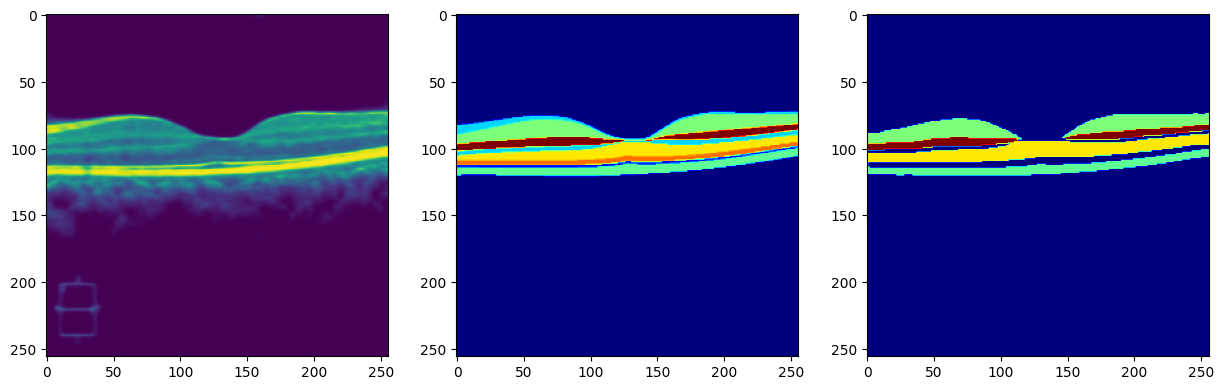

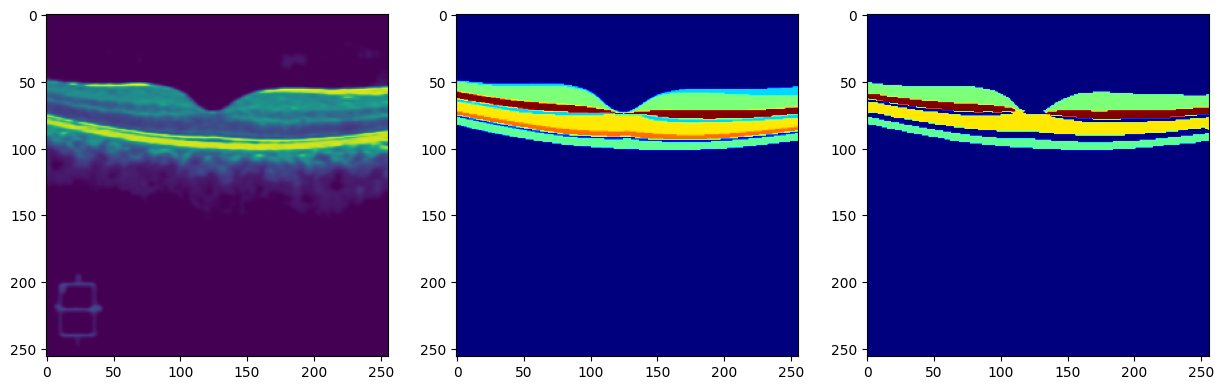

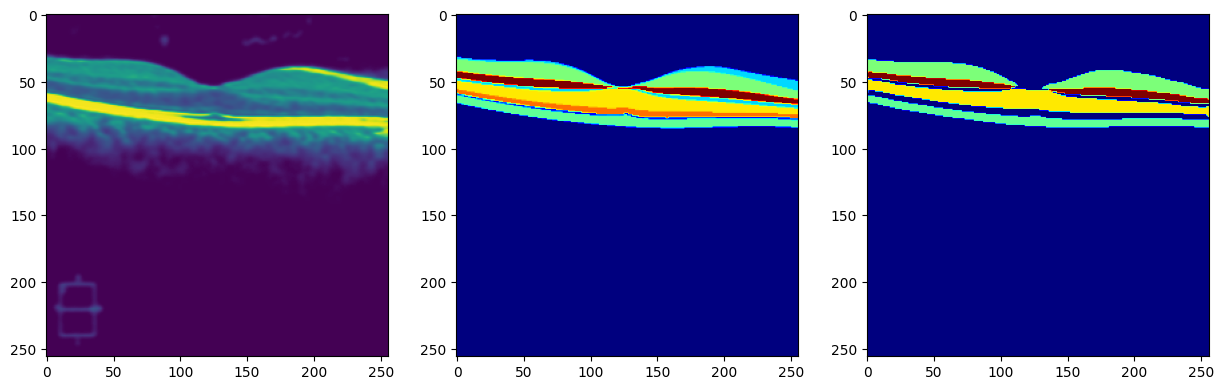

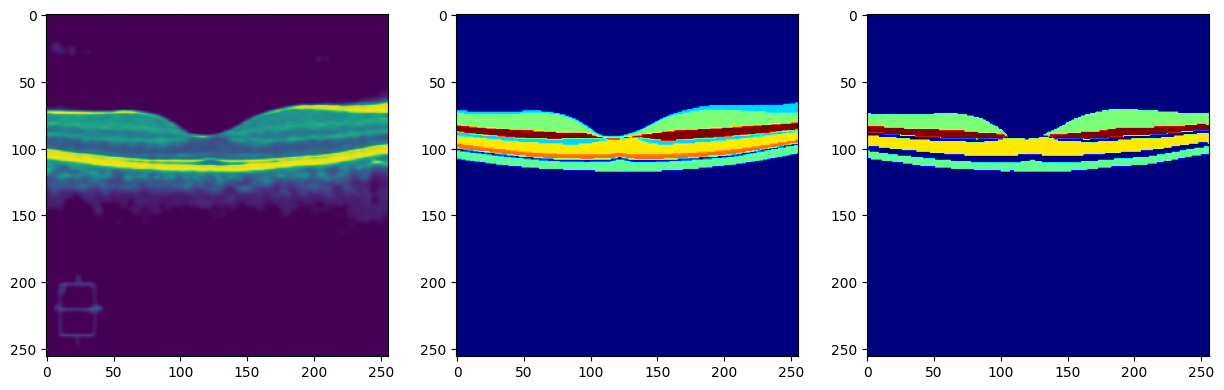

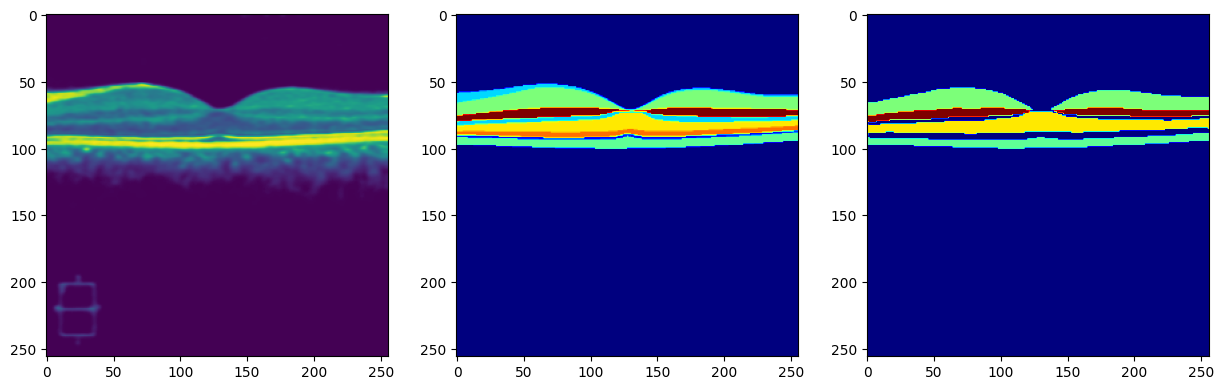

In [26]:
i=0
for img, org, msk in zip(imgs, original, pred):
#     print(org.shape,msk.shape)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(org,cmap="jet")
    plt.subplot(1,3,2)
    plt.imshow(org,cmap="jet")
    plt.subplot(1,3,3)
    plt.imshow(msk,cmap="jet")
    plt.show()
    i+=1
    if i==5:
        break